In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../casa/")
from plot_utils import *
from genome_utils import *

In [2]:
!pwd

/n/casa/analysis


# General Setup

In [3]:
ETR1_fn = '../data/jam_files/CASA__final_tycko_gata1_growth_R1.txt'
ETR2_fn = '../data/jam_files/CASA__final_tycko_gata1_growth_R2.txt'

FLR1_fn = '/n/casa/data/CRISPR_WG_paper/bassik_crispri_gata1growth.CASA_intermediate.R1.txt'
FLR2_fn = '/n/casa/data/CRISPR_WG_paper/bassik_crispri_gata1growth.CASA_intermediate.R2.txt'

fn_list = [ETR1_fn,ETR2_fn,FLR1_fn,FLR2_fn]

exp_ids = ['ETR1','ETR2','FLR1','FLR2']

fullinfo= [("WG_GATA", 1), ("WG_GATA", 2),
           ("WG_Filtered",1), ("WG_Filtered",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['Ref1'] = ('Growth paper', 1)
id2info['Ref2'] = ('ABC paper', 1)
id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

### Get peak calls from different experiments

In [4]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
ETR1_bed = '../data/jam_files/CASA__final_tycko_gata1_growth_R1__allPeaks.bed'
ETR2_bed = '../data/jam_files/CASA__final_tycko_gata1_growth_R2__allPeaks.bed'

FLR1_bed = '../data/jam_210611/CRISPR_Guide_File_Format_Data/CASA__filtered_tycko_gata1_growth_R1__allPeaks.bed'
FLR2_bed = '../data/jam_210611/CRISPR_Guide_File_Format_Data/CASA__filtered_tycko_gata1_growth_R2__allPeaks.bed'

exp_beds= [ETR1_bed, ETR2_bed, 
           FLR1_bed, FLR2_bed]

Ref1_bed= '../data/Fulco_GATA_enhancer_filter.bed'
Ref2_bed= '../data/ABC_paperPeaks_hg38.bed'
K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ Ref1_bed, Ref2_bed, K27_bed, DHS_bed ]
extra_tags = [ 'Ref1', 'Ref2', 'k27', 'DHS' ]

I'm using a truncated GFF file to specify the genes of interest in the region. TBH, I'm not 100% sure this is actually a GFF, but the table is displayed below so you understand how this file should be formatted if you are looking at a different locus. Off the top of my head, you WILL need to remove any trailing ","s in the `exonStarts` and `exonEnds` fields.

In [5]:
gff = pd.read_table('../data/GATA_locus.gff')

/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [6]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,NM_001080489.3,chrX,+,48761746,48773648,48761790,48773435,4,"48761746,48765834,48770926,48773309","48761853,48765972,48771082,48773648",NM_001080489.3,NM_001080489.3,GLOD5
1,ENST00000376670.8,chrX,+,48786553,48794311,48791109,48794164,6,"48786553,48791090,48791843,48792322,48793171,4...","48786645,48791329,48792221,48792468,48793297,4...",P15976,ENST00000376670.8,GATA1
2,ENST00000376619.6,chrX,+,48802033,48824976,48802692,48824612,29,"48802033,48802662,48802870,48803127,48805437,4...","48802170,48802785,48802999,48803216,48805522,4...",Q9UBN7,ENST00000376619.6,HDAC6


### Get guide-wise score info from different experiments

Now I'm going to collect data from each of the guide-wise count files that are compatible with our peak caller. 

I'm going to bring in `log( Low_Expression_Counts / High_Expression_Counts )` as a summary statistic for each rep. This "score" will be high for regions we think are enhancers and low for repressors (either 1st order or otherwise).

In [7]:
data = []
for i, fn in enumerate(fn_list):
    print(fn)
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    LS_norm = (1+d_pt['LS_reads']) / sum(d_pt['LS_reads'])
    HS_norm = (1+d_pt['HS_reads']) / sum(d_pt['HS_reads'])
    #d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( LS_norm / HS_norm )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )
    print(d_pt.shape)


../data/jam_files/CASA__final_tycko_gata1_growth_R1.txt
(9998, 4)
../data/jam_files/CASA__final_tycko_gata1_growth_R2.txt
(10005, 4)
/n/casa/data/CRISPR_WG_paper/bassik_crispri_gata1growth.CASA_intermediate.R1.txt
(5901, 4)
/n/casa/data/CRISPR_WG_paper/bassik_crispri_gata1growth.CASA_intermediate.R2.txt
(5901, 4)


/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.


In [8]:
data

[                   Coordinates      ETR1
 995   chrX:48745992-48746012:+  0.228550
 996   chrX:48873968-48873988:+ -0.368840
 997   chrX:48757688-48757708:- -0.222269
 998   chrX:48852374-48852394:+ -0.278887
 999   chrX:48876055-48876075:+ -0.083950
 1000  chrX:48687426-48687446:+ -0.044560
 1001  chrX:48687960-48687980:+ -0.376876
 1002  chrX:48720860-48720880:-  0.225946
 1003  chrX:48851106-48851126:- -0.226512
 1004  chrX:48792225-48792245:+  0.507060
 1005  chrX:48757477-48757497:- -0.223128
 1006  chrX:48718487-48718507:-  0.060234
 1007  chrX:48740426-48740446:-  0.081542
 1008  chrX:48883029-48883049:+  0.002494
 1009  chrX:48741278-48741298:+ -0.225300
 1010  chrX:48802660-48802680:-  0.805641
 1011  chrX:48852431-48852451:+ -0.274421
 1012  chrX:48881687-48881707:+ -0.298478
 1013  chrX:48759506-48759526:+ -0.055104
 1014  chrX:48878977-48878997:+  0.086090
 1015  chrX:48802790-48802810:+ -0.031401
 1016  chrX:48740381-48740401:+ -0.018334
 1017  chrX:48894029-48894049:- -0

In [9]:
data = pd.concat([ df.drop_duplicates(subset='Coordinates', keep='first').set_index('Coordinates') for df in data ],axis=1,join='outer',sort=False)

Finally, we'll use the guide coordinates to specify the predicted Cas9 cut-site for each guide. This will allow us to plot guide activity clearly.

In [10]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

Let get some peak tracks. Notice, all experimental peaks MUST have 6 columns, like a standard BED. However, the 5th column must be a `python` `bool` (either `True` or `False`, case-sensitive). This is a significance flag.

In [11]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 50 ]
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


Experimental track count: 4
Total track count: 8


/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.


data_copy = data.loc[ ~data['FLR1'].isnull(), ('cutsite','FLR1','FLR2') ]
data_copy['GATA1_mean'] = data_copy.loc[:,('FLR1','FLR2')].mean(axis=1)

with open('GATA1_cutsite_summary.wig','w') as f:
    print("track type=wiggle_0",file=f)
    print(f"track name='GATA1 growth'",file=f)
    print("variableStep chrom=chrX",file=f)
    data_copy.loc[:,('cutsite','GATA1_mean')] \
      .reset_index(drop=True).sort_values('cutsite') \
      .drop_duplicates(subset='cutsite', keep="first") \
      .to_csv(f, sep="\t", quoting=csv.QUOTE_NONE, index=False, header=False)


# Explore the locus

Here we're setting up a plotting function to look all all of the data from each replicate of each experiment that we specify. We're going to plot guide-wise scores at the cutsites and plot peaks on a track above.

In [12]:
#fig_h, ax_h = plot_hff_cutsites(np.array([[48397729,49657309]]), 
#          data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])


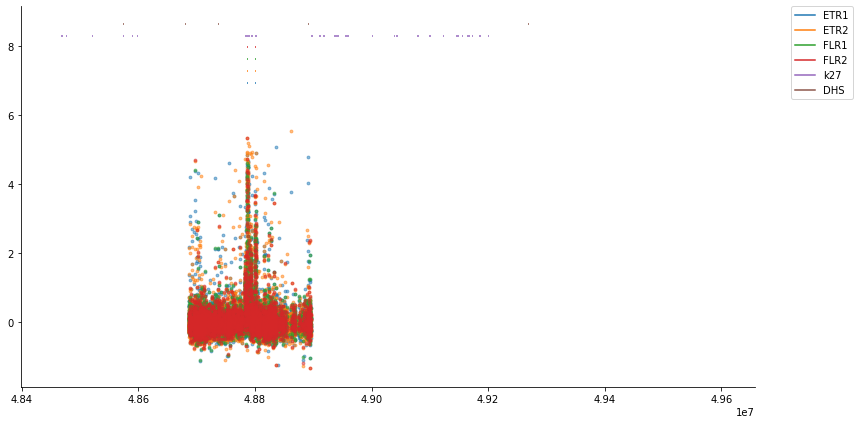

In [13]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48397729,49657309]]), 
          data, test_peaks, plot_ids=['ETR1','ETR2','FLR1','FLR2','k27','DHS'])


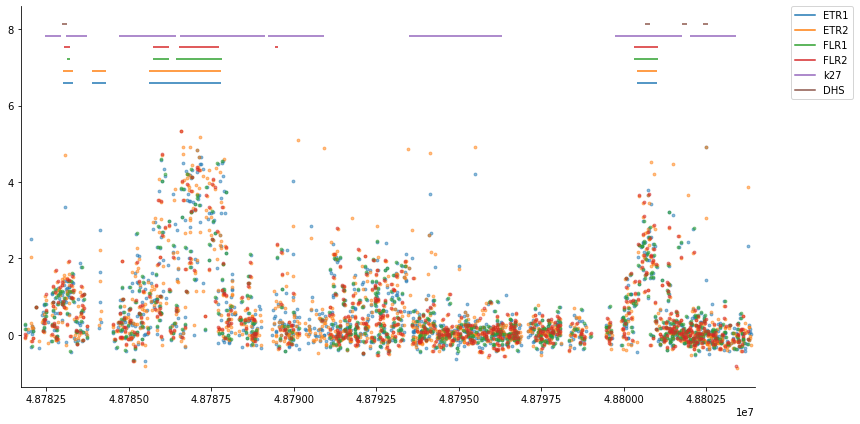

In [14]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48781722,48803966]]), 
          data, test_peaks, plot_ids=['ETR1','ETR2','FLR1','FLR2','k27','DHS'])



WG_GATA
56
WG_Filtered
7


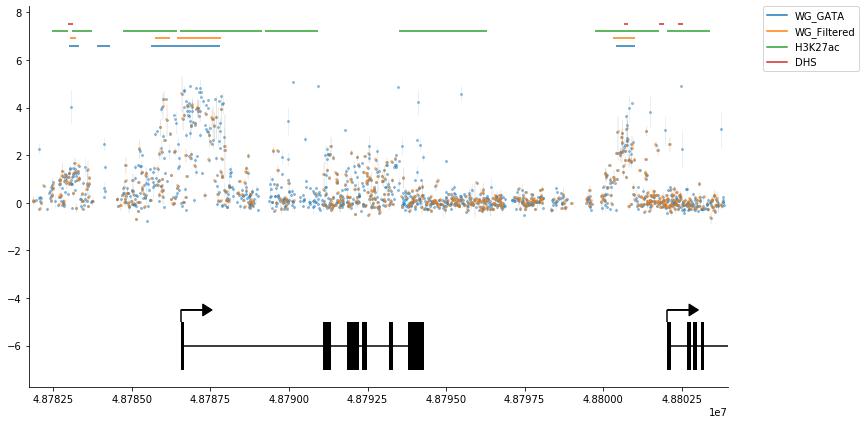

In [15]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48781722,48803966]]), 
                               data, test_peaks, plot_ids=['ETR1','ETR2','FLR1','FLR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300])
fig_h.savefig('plots/test.pdf')


In [16]:
data

,ETR1,ETR2,FLR1,FLR2,cutsite
chrX:48745992-48746012:+,0.228550,0.032778,NaN,NaN,48746008
chrX:48873968-48873988:+,-0.368840,-0.033588,NaN,NaN,48873984
chrX:48757688-48757708:-,-0.222269,-0.037911,NaN,NaN,48757691
chrX:48852374-48852394:+,-0.278887,-0.325434,NaN,NaN,48852390
chrX:48876055-48876075:+,-0.083950,-0.203323,NaN,NaN,48876071
chrX:48687426-48687446:+,-0.044560,-0.122832,NaN,NaN,48687442
chrX:48687960-48687980:+,-0.376876,-0.118571,NaN,NaN,48687976
chrX:48720860-48720880:-,0.225946,-0.137923,NaN,NaN,48720863
chrX:48851106-48851126:-,-0.226512,-0.693159,NaN,NaN,48851109
chrX:48792225-48792245:+,0.507060,0.242180,NaN,NaN,48792241


# Compare peak callers

In [17]:
def multi_region_copypasta(bed_dataframe, init_chrom=None, init_start=None, final_end=None):
    chrom = init_chrom
    start = init_start
    for i, line in bed_dataframe.iterrows():
        if start is not None:
            assert start <= line['start']
            print('\t'.join([ str(x) for x in [chrom,start,line['start']]]))
        print('\t'.join([ str(x) for x in [line['chr'],line['start'],line['end']]]))
        chrom = line['chr']
        start = line['end']
    if final_end is not None:
        print('\t'.join([ str(x) for x in [chrom,start,final_end]]))

In [18]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
CASAR_bed = '../data/CRISPR_WG_paper/GATA1/CASA__final_tycko_gata1_growth__replicatingPeaks.bed'
DESEQ_bed = '../data/CRISPR_WG_paper/GATA1/cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.adjp.hg38.bed'
MAGECKbed = '../data/CRISPR_WG_paper/GATA1/mageck_gene_summary_pval_T14_I_v_Plasmid.gene_summary.bed'
SURF__bed = '../data/CRISPR_WG_paper/GATA1/{}_significant_regions.bed'
RELICSbed = '../data/CRISPR_WG_paper/GATA1/Bassik_GATA1_CRISPRi_T21_final_k2_FS_locations.bed'

peak_beds= [CASAR_bed, DESEQ_bed, MAGECKbed, SURF__bed, RELICSbed]

peak_exp_ids = ['CASA','DESeq', 'MAGeCK', 'SURF', 'RELICS']

peak_fullinfo= [("CASA",1), ("DESeq",1), ("MAGeCK",1), ("SURF",1), ("RELICS",1)]

peak_id2info = { exp_id: info for exp_id, info in zip(peak_exp_ids, peak_fullinfo) }


K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'
cRE_bed = '../data/CRISPR_WG_paper/k562.ccres.screenhg38.bed'

extra_beds = [ K27_bed, DHS_bed, cRE_bed ]
extra_tags = [ 'k27', 'DHS', 'ccRE' ]

peak_id2info['k27'] = ('H3K27ac', 1)
peak_id2info['DHS'] = ('DHS', 1)
peak_id2info['ccRE']= ('ccRE', 1)

In [19]:
# Get experimental peaks
## Read in files
unfiltered_peaks = [
    pd.read_table(CASAR_bed, sep='\t', header=0, names=['chr','start','end'],usecols=[0,1,2]), 
    pd.read_table(DESEQ_bed, sep='\t', header=None, names=['chr','start','end'],usecols=[0,1,2]),
    pd.read_table(MAGECKbed, sep='\t', header=None, names=['chr','start','end','pval'],usecols=[0,1,2,3]),
    merge_bed( pd.concat([
        pd.read_table(SURF__bed.format('positive'), sep='\t', header=None, names=['chr','start','end'],usecols=[0,1,2]),
        pd.read_table(SURF__bed.format('negative'), sep='\t', header=None, names=['chr','start','end'],usecols=[0,1,2])
    ], axis=0) ),
    pd.read_table(RELICSbed, sep='\t', header=0, names=['chr','start','end'],usecols=[0,1,2]), 
]

unfiltered_peaks[2] = unfiltered_peaks[2].loc[ unfiltered_peaks[2]['pval'] < 0.05, ['chr','start','end'] ]

## Figure out which chromosomes were tested
tested_chr = pd.concat( unfiltered_peaks, axis=0 )['chr'].unique()

print("Experimental track count: {}".format(len(unfiltered_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ unfiltered_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
unfiltered_peaks = [ df.reset_index(drop=True) for df in unfiltered_peaks ]
print("Total track count: {}".format(len(unfiltered_peaks)))
for exp_id, peaks_idx in zip([t+"_unfiltered" for t in peak_exp_ids]+extra_tags,range(len(unfiltered_peaks))):
    print(exp_id)
    unfiltered_peaks[peaks_idx]['exp_id'] = exp_id
    unfiltered_peaks[peaks_idx]['assay'] = peak_id2info[exp_id.replace('_unfiltered',"")][0]
    unfiltered_peaks[peaks_idx]['replicate'] = peak_id2info[exp_id.replace('_unfiltered',"")][1]
    
unfiltered_peaks = pd.concat(unfiltered_peaks,axis=0,ignore_index=True)

caller_filter = (unfiltered_peaks['assay'] == 'CASA') | (unfiltered_peaks['assay'] == 'DESeq')
caller_only   = unfiltered_peaks.loc[caller_filter]


/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead.
  """
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: read_table is deprecated, use read_c

Experimental track count: 5
Total track count: 8
CASA_unfiltered
DESeq_unfiltered
MAGeCK_unfiltered
SURF_unfiltered
RELICS_unfiltered
k27
DHS
ccRE


In [20]:
unfiltered_peaks

,chr,start,end,exp_id,assay,replicate
0,chrX,48783000,48783300,CASA_unfiltered,CASA,1
1,chrX,48785600,48787800,CASA_unfiltered,CASA,1
2,chrX,48800400,48801000,CASA_unfiltered,CASA,1
3,chrX,105822500,105822600,DESeq_unfiltered,DESeq,1
4,chrX,105822600,105822700,DESeq_unfiltered,DESeq,1
5,chrX,105822700,105822800,DESeq_unfiltered,DESeq,1
6,chrX,105822800,105822900,DESeq_unfiltered,DESeq,1
7,chrX,48686400,48686500,DESeq_unfiltered,DESeq,1
8,chrX,48686500,48686600,DESeq_unfiltered,DESeq,1
9,chrX,48686600,48686700,DESeq_unfiltered,DESeq,1


In [21]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
CASAR_bed = '../data/CRISPR_WG_paper/GATA1_filtered/CASA__filtered_tycko_gata1_growth__replicatingPeaks.bed'
CASAR_bed = '/n/casa/data/CRISPR_WG_paper/test__CASA__filtered_tycko_gata1_growth__replicatingPeaks.bed'
DESEQ_bed = '../data/CRISPR_WG_paper/GATA1_filtered/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed'
MAGECKbed = '../data/CRISPR_WG_paper/GATA1_filtered/mageck_gene_summary_pval_CFD_filtered_Bassik_GATA1_CRISPRi_PLAvT21.gene_summary.bed'
SURF__bed = '../data/CRISPR_WG_paper/GATA1_filtered/{}_significant_regions.bed'
RELICSbed = '../data/CRISPR_WG_paper/GATA1_filtered/bassik_crispri_gata1growth.removelowspec_RELICS_final_k1_FS_locations.bed'

peak_beds= [CASAR_bed, DESEQ_bed, MAGECKbed, SURF__bed, RELICSbed]

peak_exp_ids = ['CASA','DESeq', 'MAGeCK', 'SURF', 'RELICS']

peak_fullinfo= [("CASA",1), ("DESeq",1), ("MAGeCK",1), ("SURF",1), ("RELICS",1)]

peak_id2info = { exp_id: info for exp_id, info in zip(peak_exp_ids, peak_fullinfo) }


K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'
cRE_bed = '../data/CRISPR_WG_paper/k562.ccres.screenhg38.bed'

extra_beds = [ K27_bed, DHS_bed, cRE_bed ]
extra_tags = [ 'k27', 'DHS', 'ccRE' ]

peak_id2info['k27'] = ('H3K27ac', 1)
peak_id2info['DHS'] = ('DHS', 1)
peak_id2info['ccRE']= ('ccRE', 1)

In [22]:
# Get experimental peaks
## Read in files
filtered_peaks = [
    pd.read_table(CASAR_bed, sep='\t', header=0, names=['chr','start','end'],usecols=[0,1,2]), 
    pd.read_table(DESEQ_bed, sep='\t', header=None, names=['chr','start','end'],usecols=[0,1,2]),
    pd.read_table(MAGECKbed, sep='\t', header=None, names=['chr','start','end','pval'],usecols=[0,1,2,3]),
    merge_bed( pd.concat([
        pd.read_table(SURF__bed.format('positive'), sep='\t', header=None, names=['chr','start','end'],usecols=[0,1,2]),
        pd.read_table(SURF__bed.format('negative'), sep='\t', header=None, names=['chr','start','end'],usecols=[0,1,2])
    ], axis=0) ),
    pd.read_table(RELICSbed, sep='\t', header=0, names=['chr','start','end'],usecols=[0,1,2]), 
]

filtered_peaks[2] = filtered_peaks[2].loc[ filtered_peaks[2]['pval'] < 0.05, ['chr','start','end'] ]

## Figure out which chromosomes were tested
tested_chr = pd.concat( filtered_peaks, axis=0 )['chr'].unique()

print("Experimental track count: {}".format(len(filtered_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ filtered_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
filtered_peaks = [ df.reset_index(drop=True) for df in filtered_peaks ]
print("Total track count: {}".format(len(filtered_peaks)))
for exp_id, peaks_idx in zip(peak_exp_ids+extra_tags,range(len(filtered_peaks))):
    print(exp_id)
    filtered_peaks[peaks_idx]['exp_id'] = exp_id
    filtered_peaks[peaks_idx]['assay'] = peak_id2info[exp_id][0]
    filtered_peaks[peaks_idx]['replicate'] = peak_id2info[exp_id][1]
    
filtered_peaks = pd.concat(filtered_peaks,axis=0,ignore_index=True)

caller_filter = (filtered_peaks['assay'] == 'CASA') | (filtered_peaks['assay'] == 'DESeq')
caller_only   = filtered_peaks.loc[caller_filter]


Experimental track count: 5


/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead.
  """
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: read_table is deprecated, use read_c

Total track count: 8
CASA
DESeq
MAGeCK
SURF
RELICS
k27
DHS
ccRE


In [23]:
peak_exp_ids+extra_tags

['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS', 'k27', 'DHS', 'ccRE']

In [24]:
filtered_peaks

,chr,start,end,exp_id,assay,replicate
0,chrX,48783025,48783225,CASA,CASA,1
1,chrX,48785725,48786225,CASA,CASA,1
2,chrX,48786425,48787825,CASA,CASA,1
3,chrX,48800325,48801025,CASA,CASA,1
4,chrX,48696600,48697000,DESeq,DESeq,1
5,chrX,48699800,48700200,DESeq,DESeq,1
6,chrX,48736400,48736800,DESeq,DESeq,1
7,chrX,48737500,48737900,DESeq,DESeq,1
8,chrX,48749500,48749700,DESeq,DESeq,1
9,chrX,48758900,48759000,DESeq,DESeq,1


In [25]:
filtered_peaks['assay'].unique()

array(['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS', 'H3K27ac', 'DHS',
       'ccRE'], dtype=object)

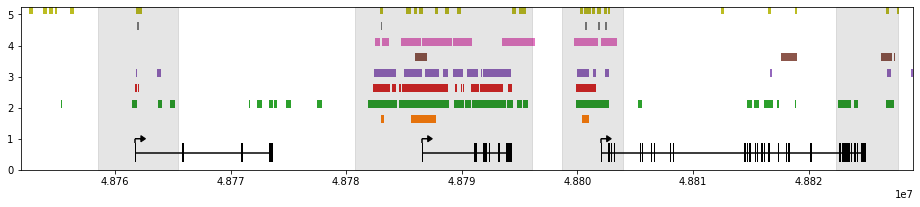

In [26]:
ymax = 5.25
ymin = 0.0
std_col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(16,3))
ax  = plt.subplot(111)
glims = [48751841,48829060]
ax.set_xlim( *glims )
ax.set_ylim(ymin, ymax)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, unfiltered_peaks.loc[unfiltered_peaks['assay']=='H3K27ac', ('chr','start','end')], ylims=[4.0,4.25], color=std_col_cycle[6])
draw_bed_blocks(ax, unfiltered_peaks.loc[unfiltered_peaks['assay']=='DHS', ('chr','start','end')], ylims=[4.50,4.75], color=std_col_cycle[7])
draw_bed_blocks(ax, unfiltered_peaks.loc[unfiltered_peaks['assay']=='ccRE', ('chr','start','end')], ylims=[5.00,5.25], color=std_col_cycle[8])

draw_bed_blocks(ax, unfiltered_peaks.loc[unfiltered_peaks['assay']=='CASA', ('chr','start','end')], ylims=[1.5,1.75], color=std_col_cycle[1])
draw_bed_blocks(ax, unfiltered_peaks.loc[unfiltered_peaks['assay']=='DESeq', ('chr','start','end')], ylims=[2.0,2.25], color=std_col_cycle[2])
draw_bed_blocks(ax, unfiltered_peaks.loc[unfiltered_peaks['assay']=='MAGeCK', ('chr','start','end')], ylims=[2.5,2.75], color=std_col_cycle[3])
draw_bed_blocks(ax, unfiltered_peaks.loc[unfiltered_peaks['assay']=='SURF', ('chr','start','end')], ylims=[3.0,3.25], color=std_col_cycle[4])
draw_bed_blocks(ax, unfiltered_peaks.loc[unfiltered_peaks['assay']=='RELICS', ('chr','start','end')], ylims=[3.5,3.75], color=std_col_cycle[5])

ax.fill_between([48758495, 48765476], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)
ax.fill_between([48780776, 48796035], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)
ax.fill_between([48798661, 48803910], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)
ax.fill_between([48822384, 48827740], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)


#plt.vlines([48758495, 48764476, 48780776,48796035, 48798661,48803910], ymin=0., ymax=4., 
#           linewidth=0.5,alpha=0.4)

plt.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__blocks_only.pdf')

plt.show()

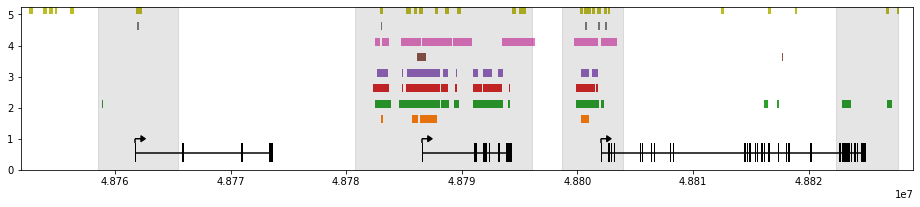

In [27]:
ymax = 5.25
ymin = 0.0
std_col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(16,3))
ax  = plt.subplot(111)
glims = [48751841,48829060]
ax.set_xlim( *glims )
ax.set_ylim(ymin, ymax)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, filtered_peaks.loc[filtered_peaks['assay']=='H3K27ac', ('chr','start','end')], ylims=[4.0,4.25], color=std_col_cycle[6])
draw_bed_blocks(ax, filtered_peaks.loc[filtered_peaks['assay']=='DHS', ('chr','start','end')], ylims=[4.50,4.75], color=std_col_cycle[7])
draw_bed_blocks(ax, filtered_peaks.loc[filtered_peaks['assay']=='ccRE', ('chr','start','end')], ylims=[5.00,5.25], color=std_col_cycle[8])

draw_bed_blocks(ax, filtered_peaks.loc[filtered_peaks['assay']=='CASA', ('chr','start','end')], ylims=[1.5,1.75], color=std_col_cycle[1])
draw_bed_blocks(ax, filtered_peaks.loc[filtered_peaks['assay']=='DESeq', ('chr','start','end')], ylims=[2.0,2.25], color=std_col_cycle[2])
draw_bed_blocks(ax, filtered_peaks.loc[filtered_peaks['assay']=='MAGeCK', ('chr','start','end')], ylims=[2.5,2.75], color=std_col_cycle[3])
draw_bed_blocks(ax, filtered_peaks.loc[filtered_peaks['assay']=='SURF', ('chr','start','end')], ylims=[3.0,3.25], color=std_col_cycle[4])
draw_bed_blocks(ax, filtered_peaks.loc[filtered_peaks['assay']=='RELICS', ('chr','start','end')], ylims=[3.5,3.75], color=std_col_cycle[5])

ax.fill_between([48758495, 48765476], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)
ax.fill_between([48780776, 48796035], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)
ax.fill_between([48798661, 48803910], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)
ax.fill_between([48822384, 48827740], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)


#plt.vlines([48758495, 48764476, 48780776,48796035, 48798661,48803910], ymin=0., ymax=4., 
#           linewidth=0.5,alpha=0.4)

plt.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__blocks_only.pdf')

plt.show()

In [28]:
filtered_peaks['assay'].unique()

array(['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS', 'H3K27ac', 'DHS',
       'ccRE'], dtype=object)

In [29]:
rgb_cycle = [
    '255,127,14',
    '44,160,44',
    '214,39,40',
    '148,103,189',
    '140,86,75'    
]

for tag, rgb_str in zip(filtered_peaks['assay'].unique()[:5], rgb_cycle):
    subgroup = filtered_peaks.loc[ filtered_peaks['assay'] == tag, ('chr','start','end') ]
    with open(f'GATA1_peak_subset__{tag}.bed', 'w') as f:
        print(f"track name={tag} color={rgb_str}",file=f)
        subgroup.to_csv(f, sep="\t", quoting=csv.QUOTE_NONE, index=False, header=False )


In [30]:
remove_chromatin_marks = (test_peaks['assay'] == 'DHS') | (test_peaks['assay'] == 'H3K27ac')


In [31]:
def plot_combined_cutsites(plot_interval, cutsite_data, peak_data, plot_ids, merge_style='replicate', 
                           get_chrom=None, figsize=None, force_xmax=None, force_xmin=None):
    # Figure out how many reps we have for each assay
    uniq_assays = list(peak_data['assay'].unique())
    assay_reps  = [ peak_data.loc[peak_data['assay'] == assay,'replicate'] \
                      .unique() 
                    for assay in uniq_assays ]
    assay_count = [ len(rep_list) for rep_list in assay_reps ]
    assay2thresh= { assay: thresh for assay, thresh in zip(uniq_assays, assay_count) }
    if get_chrom is not None:
        cutsite_data = cutsite_data[ cutsite_data.index.str.contains(get_chrom+":") ]
        peak_data    = peak_data[ peak_data['chr'] == get_chrom ]
    else:
        pass
    # Subset cutsite scores
    plot_id_slicer = [an_id for an_id in plot_ids if an_id in cutsite_data.columns]
    sub_cuts = cutsite_data.loc[:,plot_id_slicer]
    sub_cuts['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                            if coord.split(':')[-1] == '+' 
                            else 
                            int(coord.split(':')[1].split('-')[0]) + 3 
                            for coord in sub_cuts.index ]
    slice_cuts = check_overlap(plot_interval,np.vstack([cutsite_data['cutsite'].values, 
                                                       (cutsite_data['cutsite']+1).values]).T)
    sub_cuts = sub_cuts.loc[slice_cuts, :]
    # Subset peak intervals
    sub_peaks= check_overlap(plot_interval, peak_data.loc[:,('start','end')].values)
    sub_peaks= peak_data.loc[sub_peaks,:]
    sub_peaks= sub_peaks.loc[ sub_peaks['exp_id'].isin(plot_ids) ]
    
    cut_types  = np.unique(sub_cuts.columns)
    peak_types = np.unique(sub_peaks['exp_id'])
    
    score_max = np.nanmax(sub_cuts.loc[:, plot_id_slicer].values)
    score_min = np.nanmin(sub_cuts.loc[:, plot_id_slicer].values)
    score_gap = score_max - \
                score_min
    if figsize is None:
        fig = plt.figure(figsize=(12,6))
    else:
        fig = plt.figure(figsize=figsize)
    ax  = plt.subplot(111)
    avail_data = peak_data.loc[peak_data['exp_id'].isin(plot_ids),('exp_id','assay','replicate')].drop_duplicates()
    exp2assay = {}
    assay2exp = {}
    for row in avail_data.iterrows():
        exp2assay[row[1]['exp_id']] = row[1]['assay']
        try:
            assay2exp[row[1]['assay']].append(row[1]['exp_id'])
        except:
            assay2exp[row[1]['assay']] = [row[1]['exp_id']]
    for i, assay in enumerate(avail_data['assay'].unique()):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        if force_xmax is None:
            peak_position = score_max + ( ( 0.2+(i*0.05) ) * score_gap )
        else:
            peak_position = force_xmax + ( ( 0.2+(i*0.05) ) * score_gap )
        if merge_style == 'overlap':
            for exp_id in assay2exp[assay]:
                sub_sub_peaks = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
                for j, row in sub_sub_peaks.iterrows():
                    ax.hlines(y=peak_position, 
                              xmin=row['start'], xmax=row['end'],
                              color=color)
        elif merge_style == 'replicate':
            collect_merge = []
            for exp_id in assay2exp[assay]:
                exp_data  = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
                if exp_data.shape[0] > 0:
                    sub_merge = merge_bed(exp_data)
                    collect_merge.append( sub_merge )
            merge_reps = pd.DataFrame()
            if assay2thresh[assay] == 1:
                if len(collect_merge) == 1:
                    merge_reps = collect_merge[0]
                else:
                    pass
            elif len(collect_merge) > 1:
                collect_merge = pd.concat(collect_merge,axis=0).reset_index(drop=True)
                merge_reps = merge_bed(collect_merge, count=True)
                merge_reps = merge_reps[ merge_reps['count'] > 1 ]
            for j, row in merge_reps.iterrows():
                ax.hlines(y=peak_position, xmin=row['start'], xmax=row['end'], color=color)
        else:
            print("Peak merging style {} not implmented".format(merge_style))
            raise ValueError
        have_cuts = [exp_id for exp_id in assay2exp[assay] if exp_id in sub_cuts.columns]
        if len(have_cuts) > 0:
            print(assay)
            ax.scatter(sub_cuts['cutsite'],sub_cuts.loc[:,have_cuts].mean(axis=1),color=color,s=4,alpha=0.4)
            ax.vlines(x=sub_cuts['cutsite'],
                      ymin=sub_cuts.loc[:,have_cuts].min(axis=1),
                      ymax=sub_cuts.loc[:,have_cuts].max(axis=1),
                      color=color,linewidth=0.5,alpha=0.2)
            print(sum((sub_cuts.loc[:,have_cuts].max(axis=1) - sub_cuts.loc[:,have_cuts].min(axis=1)) < 0.001))
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    custom_lines = [ Line2D([0], [0], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i]) for i, assay in enumerate(avail_data['assay'].unique()) ]
    ax.legend(custom_lines[::-1][:-1], avail_data['assay'].unique()[::-1][:-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
    ax.set_xlim(*plot_interval)
    plt.tight_layout()
    return fig, ax


No handles with labels found to put in legend.


WG_Filtered
0


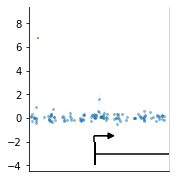

In [32]:
base_width = 48796035-48780776

nt_range = [48758495,48765476]
plt_dims = (8*((nt_range[1]-nt_range[0])/base_width),3)

fig_h, ax_h = plot_combined_cutsites(np.array([nt_range]), 
                               data, pd.concat([test_peaks.loc[~remove_chromatin_marks],filtered_peaks], axis=0), 
                               plot_ids=['FLR1','FLR2','CASA','DESeq','MAGeCK','SURF','RELICS'],
                               merge_style='overlap', figsize=plt_dims, force_xmax=6.)
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300], gene_ylim=[-4.0,-1.5])

ax_h.set_ylim(bottom=-4.5, top=9.4)

ax_h.get_xaxis().set_visible(False)

ax_h.spines['right'].set_visible(True)
ax_h.spines['right'].set_alpha(0.2)

plt.tick_params(axis='both', which='major', labelsize=10)

ax_h.legend().remove()

fig_h.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__filtered__blowup_A.pdf')


WG_Filtered
5


No handles with labels found to put in legend.


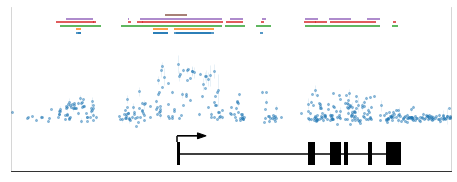

In [33]:
nt_range = [48780776,48796035]
plt_dims = (8*((nt_range[1]-nt_range[0])/base_width),3)

fig_h, ax_h = plot_combined_cutsites(np.array([nt_range]), 
                               data, pd.concat([test_peaks.loc[~remove_chromatin_marks],filtered_peaks], axis=0), 
                               plot_ids=['FLR1','FLR2','CASA','DESeq','MAGeCK','SURF','RELICS'],
                               merge_style='overlap', figsize=plt_dims, force_xmax=6.)
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300], gene_ylim=[-4.0,-1.5])

ax_h.legend().remove()

plt.tick_params(axis='both', which='major', labelsize=10)

ax_h.spines['left'].set_alpha(0.2)
ax_h.spines['right'].set_visible(True)
ax_h.spines['right'].set_alpha(0.2)

ax_h.get_xaxis().set_visible(False)

ax_h.get_yaxis().set_visible(False)
ax_h.set_ylim(bottom=-4.5, top=9.4)


fig_h.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__filtered__blowup_B.pdf')


No handles with labels found to put in legend.


WG_Filtered
2


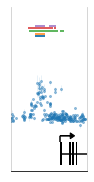

In [34]:
nt_range = [48798661,48803910]
plt_dims = (8*((nt_range[1]-nt_range[0])/base_width),3)

fig_h, ax_h = plot_combined_cutsites(np.array([nt_range]), 
                               data, pd.concat([test_peaks.loc[~remove_chromatin_marks],filtered_peaks], axis=0), 
                               plot_ids=['FLR1','FLR2','CASA','DESeq','MAGeCK','SURF','RELICS'],
                               merge_style='overlap', figsize=plt_dims, force_xmax=6.)
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300], gene_ylim=[-4.0,-1.5])

ax_h.legend().remove()

plt.tick_params(axis='both', which='major', labelsize=10)

ax_h.get_yaxis().set_visible(False)
ax_h.get_xaxis().set_visible(False)

ax_h.spines['left'].set_alpha(0.2)
ax_h.spines['right'].set_visible(True)
ax_h.spines['right'].set_alpha(0.2)


ax_h.set_ylim(bottom=-4.5, top=9.4)


fig_h.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__filtered__blowup_C.pdf')


WG_Filtered
2


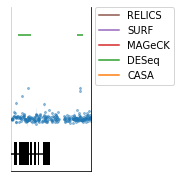

In [35]:
nt_range = [48822384, 48827740]
plt_dims = (8*((nt_range[1]-nt_range[0])/base_width),3)

fig_h, ax_h = plot_combined_cutsites(np.array([nt_range]), 
                               data, pd.concat([test_peaks.loc[~remove_chromatin_marks],filtered_peaks
                                               ], axis=0), 
                               plot_ids=['FLR1','FLR2','CASA','DESeq','MAGeCK','SURF','RELICS'],
                               merge_style='overlap', figsize=plt_dims, force_xmax=6.)
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300], gene_ylim=[-4.0,-1.5])

plt.tick_params(axis='both', which='major', labelsize=10)

ax_h.spines['left'].set_visible(True)
ax_h.get_yaxis().set_visible(False)
ax_h.get_xaxis().set_visible(False)

ax_h.spines['left'].set_alpha(0.2)
ax_h.spines['right'].set_visible(True)


ax_h.set_ylim(bottom=-4.5, top=9.4)

fig_h.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__filtered__blowup_D.pdf')


No handles with labels found to put in legend.


WG_GATA
3


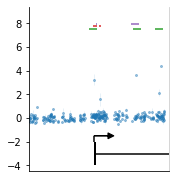

In [36]:
base_width = 48796035-48780776

nt_range = [48758495,48765476]
plt_dims = (8*((nt_range[1]-nt_range[0])/base_width),3)

fig_h, ax_h = plot_combined_cutsites(np.array([nt_range]), 
                               data, pd.concat([test_peaks.loc[~remove_chromatin_marks],unfiltered_peaks], axis=0), 
                               plot_ids=['ETR1','ETR2','CASA_unfiltered','DESeq_unfiltered','MAGeCK_unfiltered','SURF_unfiltered','RELICS_unfiltered'],
                               merge_style='overlap', figsize=plt_dims, force_xmax=6.)
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300], gene_ylim=[-4.0,-1.5])

ax_h.set_ylim(bottom=-4.5, top=9.4)

ax_h.get_xaxis().set_visible(False)

ax_h.spines['right'].set_visible(True)
ax_h.spines['right'].set_alpha(0.2)

plt.tick_params(axis='both', which='major', labelsize=10)

ax_h.legend().remove()

fig_h.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__unfiltered__blowup_A.pdf')


WG_GATA
50


No handles with labels found to put in legend.


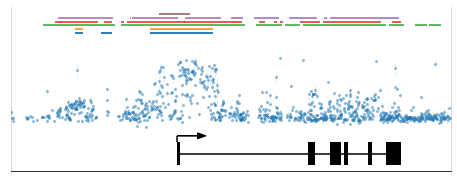

In [37]:
nt_range = [48780776,48796035]
plt_dims = (8*((nt_range[1]-nt_range[0])/base_width),3)

fig_h, ax_h = plot_combined_cutsites(np.array([nt_range]), 
                               data, pd.concat([test_peaks.loc[~remove_chromatin_marks],unfiltered_peaks], axis=0), 
                               plot_ids=['ETR1','ETR2','CASA_unfiltered','DESeq_unfiltered','MAGeCK_unfiltered','SURF_unfiltered','RELICS_unfiltered'],
                               merge_style='overlap', figsize=plt_dims, force_xmax=6.)
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300], gene_ylim=[-4.0,-1.5])

ax_h.legend().remove()

plt.tick_params(axis='both', which='major', labelsize=10)

ax_h.spines['left'].set_alpha(0.2)
ax_h.spines['right'].set_visible(True)
ax_h.spines['right'].set_alpha(0.2)

ax_h.get_xaxis().set_visible(False)

ax_h.get_yaxis().set_visible(False)
ax_h.set_ylim(bottom=-4.5, top=9.4)


fig_h.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__unfiltered__blowup_B.pdf')


No handles with labels found to put in legend.


WG_GATA
6


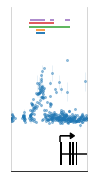

In [38]:
nt_range = [48798661,48803910]
plt_dims = (8*((nt_range[1]-nt_range[0])/base_width),3)

fig_h, ax_h = plot_combined_cutsites(np.array([nt_range]), 
                               data, pd.concat([test_peaks.loc[~remove_chromatin_marks],unfiltered_peaks], axis=0), 
                               plot_ids=['ETR1','ETR2','CASA_unfiltered','DESeq_unfiltered','MAGeCK_unfiltered','SURF_unfiltered','RELICS_unfiltered'],
                               merge_style='overlap', figsize=plt_dims, force_xmax=6.)
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300], gene_ylim=[-4.0,-1.5])

ax_h.legend().remove()

plt.tick_params(axis='both', which='major', labelsize=10)

ax_h.get_yaxis().set_visible(False)
ax_h.get_xaxis().set_visible(False)

ax_h.spines['left'].set_alpha(0.2)
ax_h.spines['right'].set_visible(True)
ax_h.spines['right'].set_alpha(0.2)


ax_h.set_ylim(bottom=-4.5, top=9.4)


fig_h.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__unfiltered__blowup_C.pdf')


WG_GATA
4


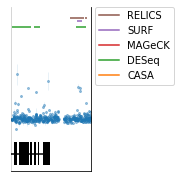

In [39]:
nt_range = [48822384, 48827740]
plt_dims = (8*((nt_range[1]-nt_range[0])/base_width),3)

fig_h, ax_h = plot_combined_cutsites(np.array([nt_range]), 
                               data, pd.concat([test_peaks.loc[~remove_chromatin_marks],unfiltered_peaks
                                               ], axis=0), 
                               plot_ids=['ETR1','ETR2','CASA_unfiltered','DESeq_unfiltered','MAGeCK_unfiltered','SURF_unfiltered','RELICS_unfiltered'],
                               merge_style='overlap', figsize=plt_dims, force_xmax=6.)
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300], gene_ylim=[-4.0,-1.5])

plt.tick_params(axis='both', which='major', labelsize=10)

ax_h.spines['left'].set_visible(True)
ax_h.get_yaxis().set_visible(False)
ax_h.get_xaxis().set_visible(False)

ax_h.spines['left'].set_alpha(0.2)
ax_h.spines['right'].set_visible(True)


ax_h.set_ylim(bottom=-4.5, top=9.4)

fig_h.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__unfiltered__blowup_D.pdf')


# ENCODE feature overlap

In [40]:
filtered_peaks.loc[ filtered_peaks['exp_id'] == 'SURF' ]

,chr,start,end,exp_id,assay,replicate
120,chrX,48696667,48697047,SURF,SURF,1
121,chrX,48697067,48697227,SURF,SURF,1
122,chrX,48702727,48702867,SURF,SURF,1
123,chrX,48737607,48737707,SURF,SURF,1
124,chrX,48782687,48783647,SURF,SURF,1
125,chrX,48784847,48784887,SURF,SURF,1
126,chrX,48785247,48788107,SURF,SURF,1
127,chrX,48788387,48788847,SURF,SURF,1
128,chrX,48789487,48789627,SURF,SURF,1
129,chrX,48790967,48791427,SURF,SURF,1


In [41]:
unfiltered_peaks

,chr,start,end,exp_id,assay,replicate
0,chrX,48783000,48783300,CASA_unfiltered,CASA,1
1,chrX,48785600,48787800,CASA_unfiltered,CASA,1
2,chrX,48800400,48801000,CASA_unfiltered,CASA,1
3,chrX,105822500,105822600,DESeq_unfiltered,DESeq,1
4,chrX,105822600,105822700,DESeq_unfiltered,DESeq,1
5,chrX,105822700,105822800,DESeq_unfiltered,DESeq,1
6,chrX,105822800,105822900,DESeq_unfiltered,DESeq,1
7,chrX,48686400,48686500,DESeq_unfiltered,DESeq,1
8,chrX,48686500,48686600,DESeq_unfiltered,DESeq,1
9,chrX,48686600,48686700,DESeq_unfiltered,DESeq,1


In [42]:
def count_nt_inside_and_outside(ref, test):
    ref_nt = sum(ref['end'] - ref['start'])
    test_nt = sum(test['end'] - test['start'])
    intersect = intersect_bed3(ref.values, test.values)
    in_nt = sum(intersect['end'] - intersect['start'])
    out_nt= test_nt - in_nt
    return {'inside': in_nt, 'outside': out_nt, 'reference': ref_nt}

def cniao_wrapper(data, ref_id, test_id, filter_tag='exp_id', 
                  locus_chr=None, locus_start=None, locus_end=None):

    col_names = ('chr', 'start', 'end')

    if (locus_chr is not None) and (locus_start is not None) and (locus_end is not None):
        intervals = data.loc[:, col_names].values
        locus = np.array([locus_chr, locus_start, locus_end])
        locus_filter = check_overlap_bed(locus, intervals)
        use_data = data.loc[ locus_filter ]
    else:
        use_data = data
    
    ref = use_data.loc[ use_data[filter_tag] == ref_id.format(test_id), col_names ]
    test= use_data.loc[ use_data[filter_tag] == test_id,col_names ]
    return dict({'reference_id': ref_id, 'test_id': test_id}, **count_nt_inside_and_outside(ref, test))

def plot_clustered_stacked(data, labels=None, title="bar plot", H="/", **kwargs):
    groups= 'test_id'
    stacks= 'reference_id'
    layers= ['inside','outside']
    
    n_groups = len(data[groups].unique())
    n_stacks = len(data[stacks].unique())
    n_layers = len(layers)
    
    fig = plt.figure(figsize=(20,15))
    axe = plt.subplot(111)
    
    print(f"{n_groups} groups, {n_stacks} stacks, {n_layers} layers", file=sys.stderr)
    
    for stack_idx in range(n_stacks):
        subset = data.loc[ data[stacks] == data[stacks].unique()[stack_idx], layers+[groups] ].set_index(groups)
        axe = subset.plot(
            kind = 'bar',
            linewidth=0,
            alpha=np.linspace(1.0,0.0,n_stacks+1)[stack_idx],
            stacked=True,
            ax=axe,
            legend=False,
            grid=False,
            **kwargs
        )
        
    h, l = axe.get_legend_handles_labels()
    for i in range(0, n_stacks*n_layers, n_layers):
        for j, pa in enumerate(h[i:i+n_layers]):
            for rect in pa.patches:
                rect.set_x(rect.get_x()+ 1 / float(n_stacks + 1) * i / float(n_layers))
                rect.set_hatch(H * int(i / n_layers))
                rect.set_width(1 / float(n_stacks + 1))
                
    axe.set_xticks((np.arange(0, 2 * n_groups, 2) + 1 / float(n_groups + 1)) / 2.)
    axe.set_xticklabels(subset.index, rotation=90)
    axe.set_yticklabels([ int(y) for y in axe.get_yticks()],rotation=90)
    axe.set_title(title)
    
    n=[]
    for i in range(n_stacks):
        n.append(axe.bar(0,0,color='gray', alpha=np.linspace(1.0,0.0,n_stacks+1)[i], hatch=H*i))
        
    l1 = axe.legend(h[:n_layers], l[:n_layers], loc=[1.01, 0.5], fontsize=24)
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1], fontsize=24)
    axe.add_artist(l1)
    return fig, axe

In [43]:
np.linspace(1.0,0.0,4)

array([1.        , 0.66666667, 0.33333333, 0.        ])

In [44]:
peak_exp_ids

['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']

In [45]:
overlap_tests = []
for ref_id in extra_tags:
    for test_id in peak_exp_ids:
        overlap_tests.append( 
            cniao_wrapper(filtered_peaks, ref_id, test_id, locus_chr='chrX', locus_start=48751841, locus_end=48829060)
        )

overlap_tests = pd.DataFrame(overlap_tests)
norm_overlap_tests = overlap_tests.copy()
relative_overlap_tests = overlap_tests.copy()

norm_overlap_tests['inside'] = norm_overlap_tests['inside'] / norm_overlap_tests['reference']
norm_overlap_tests['outside'] = norm_overlap_tests['outside'] / norm_overlap_tests['reference']

relative_overlap_tests['inside'] = relative_overlap_tests['inside'] / (overlap_tests['inside'] + overlap_tests['outside'])
relative_overlap_tests['outside'] = relative_overlap_tests['outside'] / (overlap_tests['inside'] + overlap_tests['outside'])


In [46]:
overlap_tests.set_index('test_id')

,inside,outside,reference,reference_id
test_id,,,,
CASA,2626,174,13353,k27
DESeq,8038,4962,13353,k27
MAGeCK,6788,2807,13353,k27
SURF,5499,1841,13353,k27
RELICS,657,209,13353,k27
CASA,250,2550,750,DHS
DESeq,425,12575,750,DHS
MAGeCK,302,9293,750,DHS
SURF,312,7028,750,DHS


5 groups, 3 stacks, 2 layers


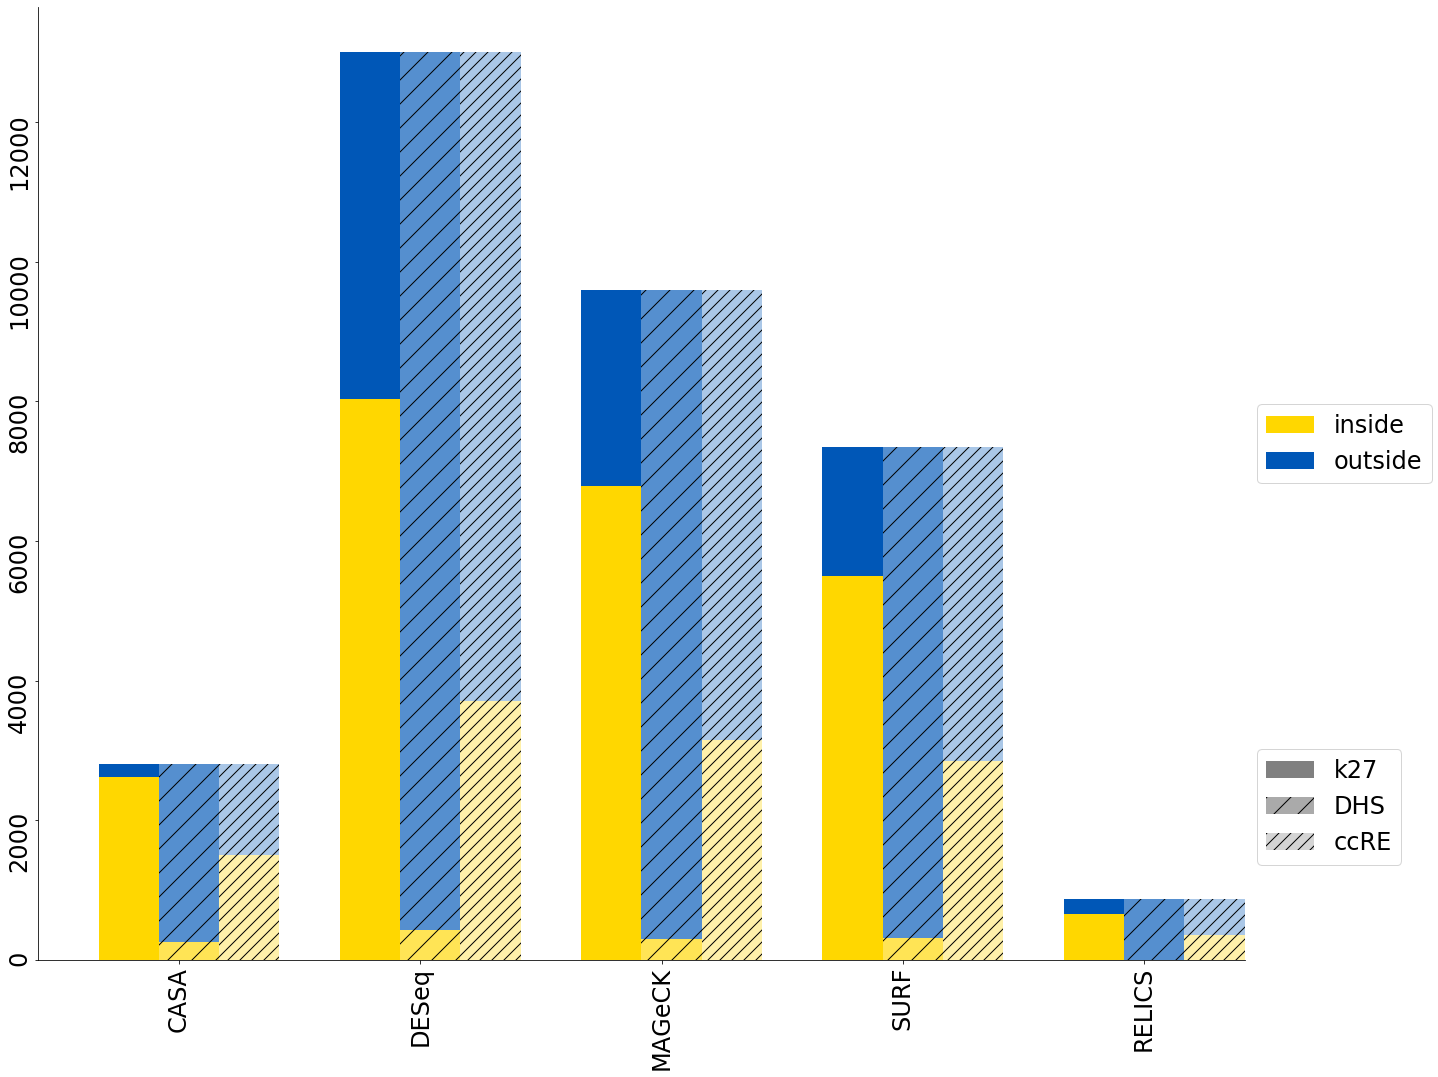

In [47]:
fig_o, axe_o = plot_clustered_stacked(overlap_tests, ['k27', 'DHS', 'ccRE'], color=['#ffd700', '#0057b7'], title='',H='/')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.xlabel('', fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=24)


axe_o.spines['right'].set_visible(False)
axe_o.spines['top'].set_visible(False)

fig_o.savefig('CRISPR_WG/plots/CRISPR_WG_GATA_reference_overlap.linscale.pdf')
plt.tight_layout()
plt.show()

In [48]:
agg_peaks = pd.concat([ unfiltered_peaks.loc[ unfiltered_peaks['exp_id'].str.contains('unfil') ], filtered_peaks ], axis=0)


In [49]:
agg_peaks

,chr,start,end,exp_id,assay,replicate
0,chrX,48783000,48783300,CASA_unfiltered,CASA,1
1,chrX,48785600,48787800,CASA_unfiltered,CASA,1
2,chrX,48800400,48801000,CASA_unfiltered,CASA,1
3,chrX,105822500,105822600,DESeq_unfiltered,DESeq,1
4,chrX,105822600,105822700,DESeq_unfiltered,DESeq,1
5,chrX,105822700,105822800,DESeq_unfiltered,DESeq,1
6,chrX,105822800,105822900,DESeq_unfiltered,DESeq,1
7,chrX,48686400,48686500,DESeq_unfiltered,DESeq,1
8,chrX,48686500,48686600,DESeq_unfiltered,DESeq,1
9,chrX,48686600,48686700,DESeq_unfiltered,DESeq,1


In [50]:
agg_peaks['exp_id'].unique()

array(['CASA_unfiltered', 'DESeq_unfiltered', 'MAGeCK_unfiltered',
       'SURF_unfiltered', 'RELICS_unfiltered', 'CASA', 'DESeq', 'MAGeCK',
       'SURF', 'RELICS', 'k27', 'DHS', 'ccRE'], dtype=object)

In [51]:
overlap_tests = []
for ref_id in extra_tags + ['self']:
    for test_id in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
        if ref_id == 'self':
            use_ref = test_id + '_unfiltered'
        else:
            use_ref = ref_id
        overlap_tests.append( 
            cniao_wrapper(agg_peaks, use_ref, test_id, locus_chr='chrX', locus_start=48751841, locus_end=48829060)
        )

overlap_tests = pd.DataFrame(overlap_tests)
norm_overlap_tests = overlap_tests.copy()
relative_overlap_tests = overlap_tests.copy()

norm_overlap_tests['inside'] = norm_overlap_tests['inside'] / norm_overlap_tests['reference']
norm_overlap_tests['outside'] = norm_overlap_tests['outside'] / norm_overlap_tests['reference']

relative_overlap_tests['inside'] = relative_overlap_tests['inside'] / (overlap_tests['inside'] + overlap_tests['outside'])
relative_overlap_tests['outside'] = relative_overlap_tests['outside'] / (overlap_tests['inside'] + overlap_tests['outside'])




In [52]:
overlap_tests.set_index('test_id')

,inside,outside,reference,reference_id
test_id,,,,
CASA,2626,174,13353,k27
DESeq,8038,4962,13353,k27
MAGeCK,6788,2807,13353,k27
SURF,5499,1841,13353,k27
RELICS,657,209,13353,k27
CASA,250,2550,750,DHS
DESeq,425,12575,750,DHS
MAGeCK,302,9293,750,DHS
SURF,312,7028,750,DHS


In [53]:
overlap_tests.iloc[-5:]['reference_id'] = 'unfiltered'

/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


5 groups, 4 stacks, 2 layers


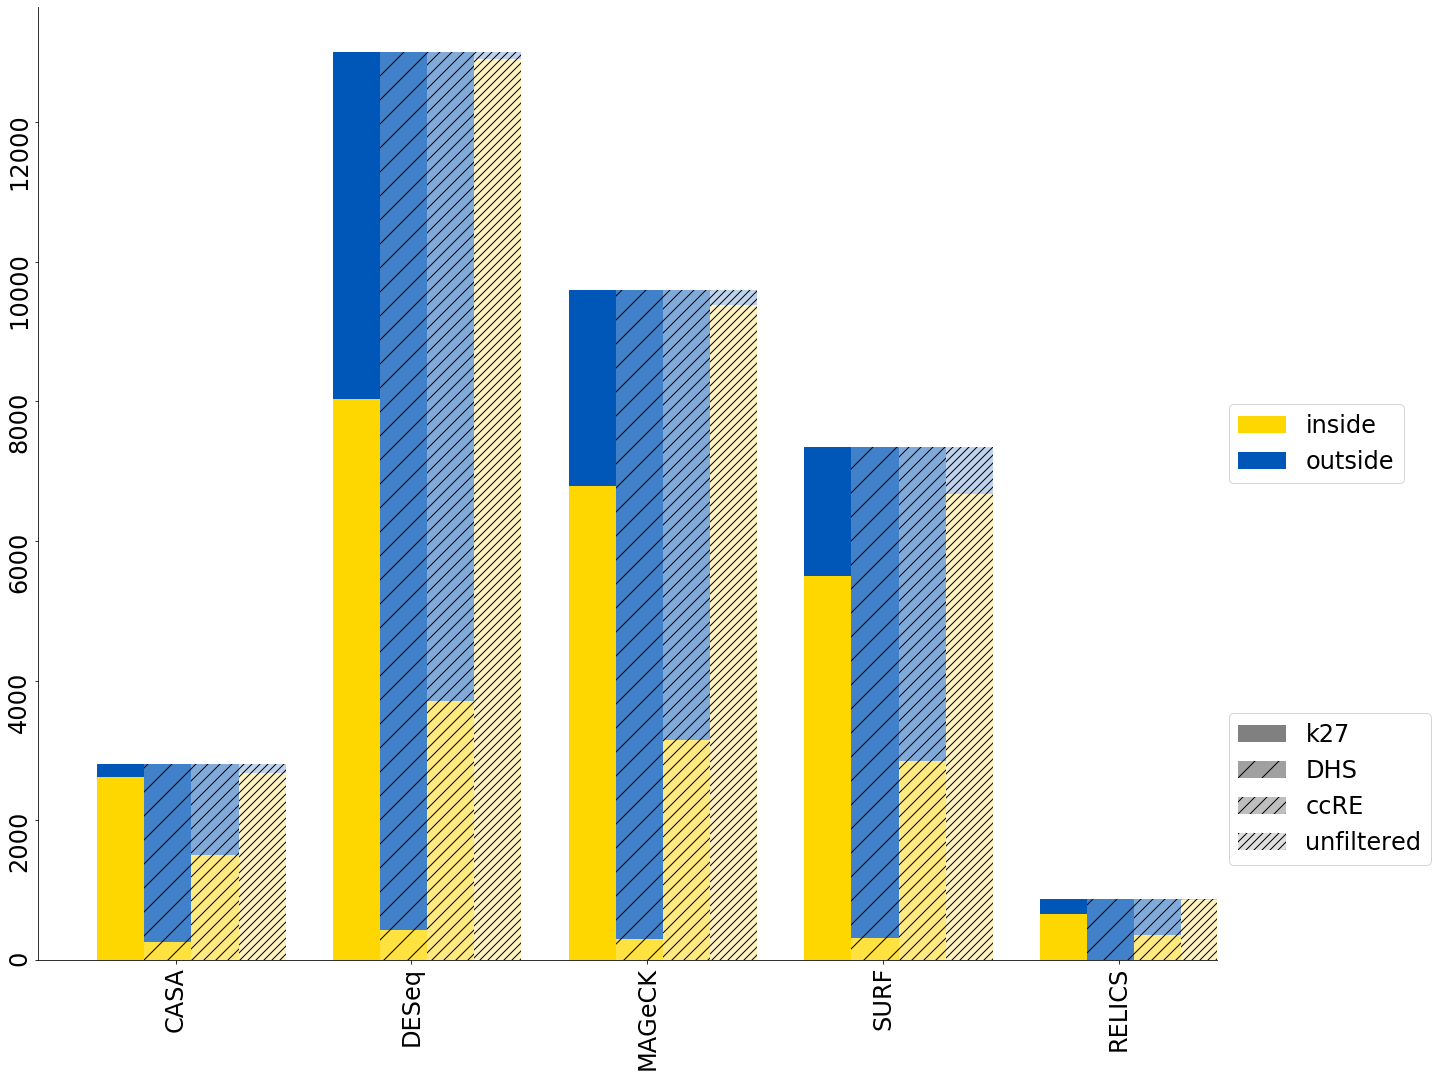

In [54]:
fig_o, axe_o = plot_clustered_stacked(overlap_tests, ['k27', 'DHS', 'ccRE', 'unfiltered'], color=['#ffd700', '#0057b7'], title='',H='/')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.xlabel('', fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=24)


axe_o.spines['right'].set_visible(False)
axe_o.spines['top'].set_visible(False)

fig_o.savefig('CRISPR_WG/plots/CRISPR_WG_GATA_reference_overlap.linscale.pdf')
plt.tight_layout()
plt.show()

In [55]:
relative_overlap_tests.loc[ relative_overlap_tests['reference_id'].str.contains('unfiltered'), 'reference_id' ] = 'unfiltered'
relative_overlap_tests

,inside,outside,reference,reference_id,test_id
0,0.937857,0.062143,13353,k27,CASA
1,0.618308,0.381692,13353,k27,DESeq
2,0.707452,0.292548,13353,k27,MAGeCK
3,0.749183,0.250817,13353,k27,SURF
4,0.758661,0.241339,13353,k27,RELICS
5,0.089286,0.910714,750,DHS,CASA
6,0.032692,0.967308,750,DHS,DESeq
7,0.031475,0.968525,750,DHS,MAGeCK
8,0.042507,0.957493,750,DHS,SURF
9,0.000000,1.000000,750,DHS,RELICS


5 groups, 4 stacks, 2 layers


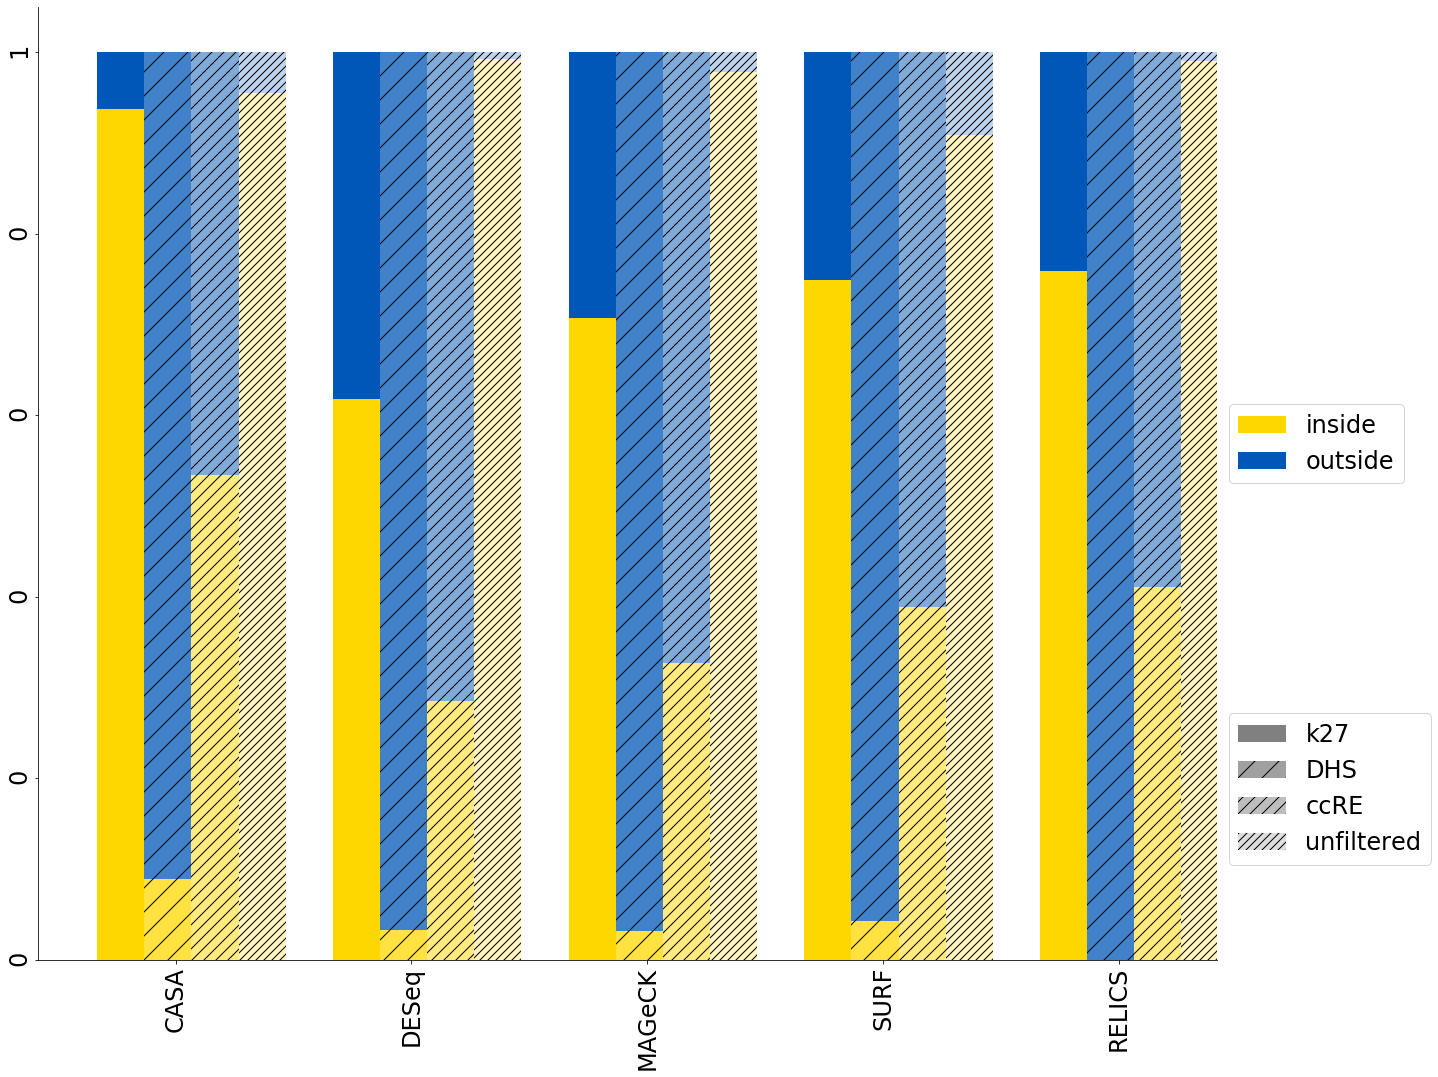

In [56]:
fig_o, axe_o = plot_clustered_stacked(relative_overlap_tests, ['k27', 'DHS', 'ccRE', 'unfiltered'], color=['#ffd700', '#0057b7'], title='',H='/')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.xlabel('', fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=24)


axe_o.spines['right'].set_visible(False)
axe_o.spines['top'].set_visible(False)

fig_o.savefig('CRISPR_WG/plots/CRISPR_WG_GATA_reference_overlap.linscale.pdf')
plt.tight_layout()
plt.show()

5 groups, 4 stacks, 2 layers


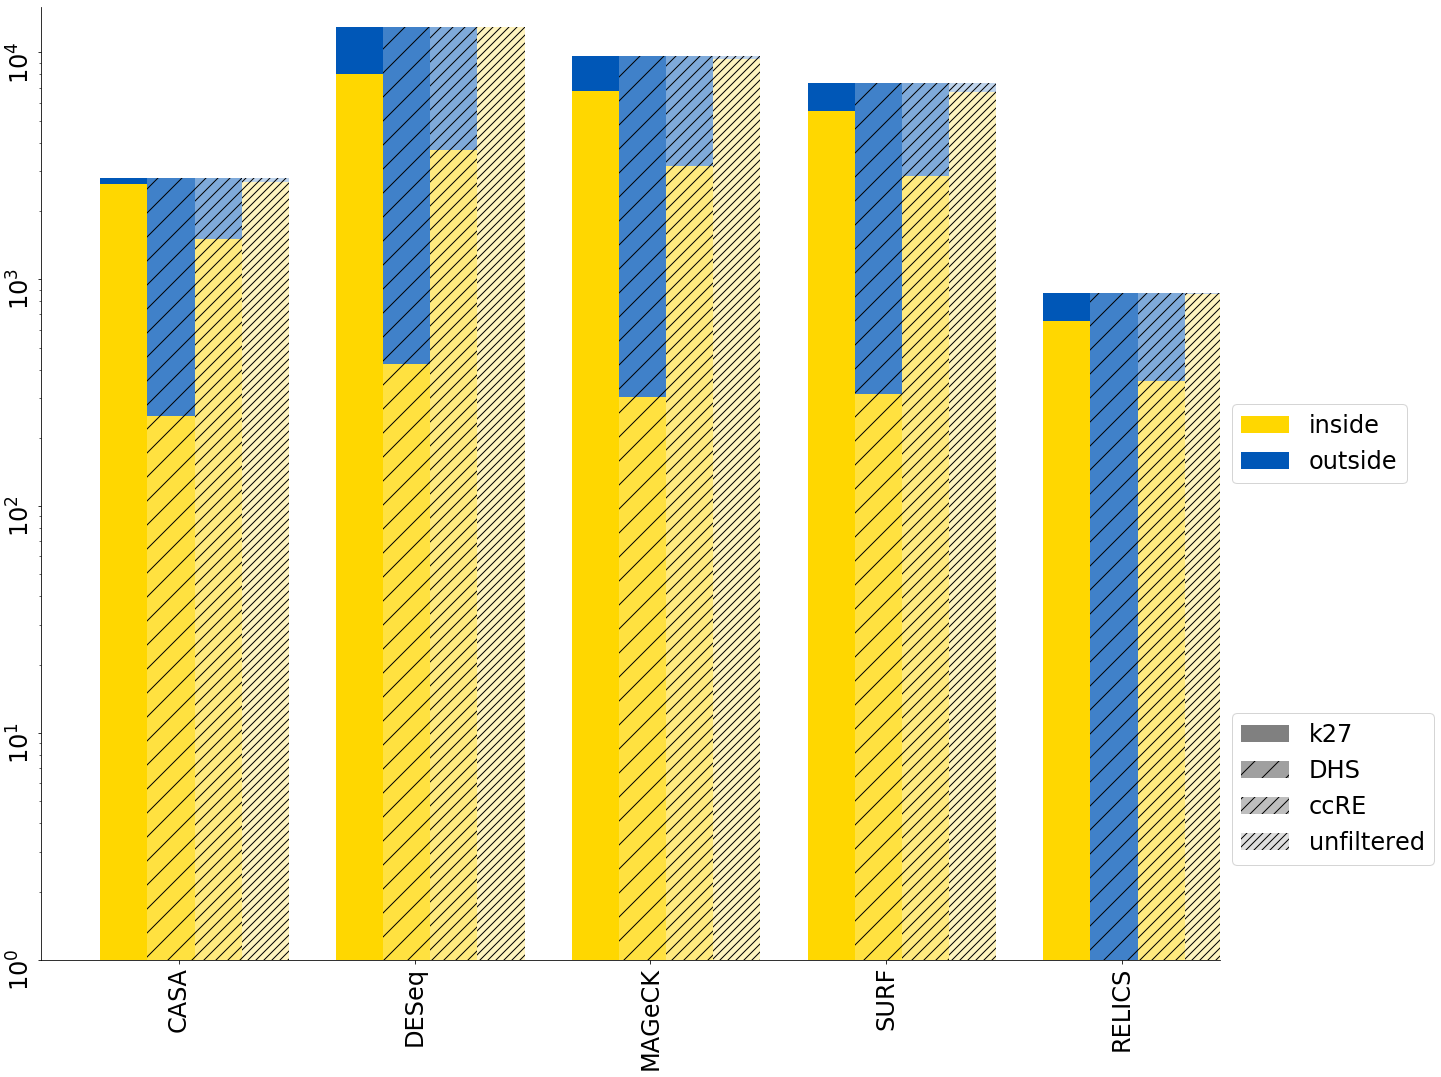

In [57]:
fig_o, axe_o = plot_clustered_stacked(overlap_tests, ['k27', 'DHS', 'ccRE','unfiltered'], color=['#ffd700', '#0057b7'], title='',H='/')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.xlabel('', fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=24)


axe_o.spines['right'].set_visible(False)
axe_o.spines['top'].set_visible(False)

plt.yscale('log')
plt.ylim(1)

fig_o.savefig('CRISPR_WG/plots/CRISPR_WG_GATA_reference_overlap.logscale.pdf')
plt.tight_layout()
plt.show()

# Peak guide effect

In [58]:
data

,ETR1,ETR2,FLR1,FLR2,cutsite
chrX:48745992-48746012:+,0.228550,0.032778,NaN,NaN,48746008
chrX:48873968-48873988:+,-0.368840,-0.033588,NaN,NaN,48873984
chrX:48757688-48757708:-,-0.222269,-0.037911,NaN,NaN,48757691
chrX:48852374-48852394:+,-0.278887,-0.325434,NaN,NaN,48852390
chrX:48876055-48876075:+,-0.083950,-0.203323,NaN,NaN,48876071
chrX:48687426-48687446:+,-0.044560,-0.122832,NaN,NaN,48687442
chrX:48687960-48687980:+,-0.376876,-0.118571,NaN,NaN,48687976
chrX:48720860-48720880:-,0.225946,-0.137923,NaN,NaN,48720863
chrX:48851106-48851126:-,-0.226512,-0.693159,NaN,NaN,48851109
chrX:48792225-48792245:+,0.507060,0.242180,NaN,NaN,48792241


In [59]:
filtered_peaks['assay'].unique()

array(['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS', 'H3K27ac', 'DHS',
       'ccRE'], dtype=object)

### Filtered

In [60]:
peak_groups = {}
peak_groups['all'] = merge_bed(filtered_peaks.loc[ ~filtered_peaks['assay'].str.contains('DHS|ccRE|H3K27ac') ])
for assay in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
    peak_groups[assay] = merge_bed(filtered_peaks.loc[ filtered_peaks['assay'].str.contains(assay) ])

In [61]:
peak_groups

{'all':      chr     start       end
 0   chrX  48696600  48697047
 1   chrX  48697067  48697227
 2   chrX  48699800  48700200
 3   chrX  48702727  48702867
 4   chrX  48732248  48732404
 5   chrX  48736400  48736800
 6   chrX  48737500  48737900
 7   chrX  48749500  48749700
 8   chrX  48758900  48759000
 9   chrX  48782347  48783900
 10  chrX  48784600  48788148
 11  chrX  48788200  48788900
 12  chrX  48789300  48789800
 13  chrX  48790947  48793600
 14  chrX  48794000  48794200
 15  chrX  48799847  48801900
 16  chrX  48802000  48802300
 17  chrX  48816100  48816500
 18  chrX  48817300  48817400
 19  chrX  48817695  48817795
 20  chrX  48822900  48823700
 21  chrX  48826800  48827200
 22  chrX  48831800  48832500
 23  chrX  48891800  48892200
 24  chrX  48893900  48894300, 'CASA':     chr     start       end
 0  chrX  48783025  48783225
 1  chrX  48785725  48786225
 2  chrX  48786425  48787825
 3  chrX  48800325  48801025, 'DESeq':      chr     start       end
 0   chrX  48696600  

In [62]:
chrom_filter = data['cutsite'].index.str.contains('chrX')
guide_hits = {}
for assay in ['all', 'CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
    guide_hits[assay] = []
    for i, guide in data.iterrows():
        cut_site = np.array([i.split(':')[0], int(guide['cutsite']), int(guide['cutsite']+1)])
        overlaps = check_overlap_bed(cut_site, peak_groups[assay].loc[:,('chr','start','end')].values)
        guide_hits[assay].append( overlaps.sum() > 0 )

    guide_hits[assay] = np.array(guide_hits[assay])

In [64]:
ttests = {}
df_misses = pd.DataFrame( {'score': data.loc[~guide_hits['all'],('ETR1','ETR2')].mean(axis=1), 'assay': 'misses'} )
df_misses = df_misses.loc[ ~df_misses['score'].isna() ]

df_marked = []
df_shufmrk= []
for assay in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
    na_filter = data.loc[:,('ETR1','ETR2')].mean(axis=1).isna()
    
    df_marked.append( 
        pd.DataFrame( {'score': data.loc[guide_hits[assay],('ETR1','ETR2')].mean(axis=1), 'assay': assay} )
    )
    df_shufmrk.append( 
        pd.DataFrame( {'score': data.loc[~na_filter,('ETR1','ETR2')].sample(n=guide_hits[assay].sum()).mean(axis=1), 'assay': assay} )
    )
    df_marked[-1] = df_marked[-1].loc[ ~df_marked[-1]['score'].isna() ]
    ttests[assay] = stats.ttest_ind(df_marked[-1]['score'], df_shufmrk[-1]['score'], equal_var=False)
    
df_marked = pd.concat( df_marked, axis=0 )
df_shufmrk = pd.concat( df_shufmrk, axis=0 )
df_marked['shuffled'] = 'False'

#ttests = {}
#for assay in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
#    ttests[assay] = stats.ttest_ind(df_marked.loc[ df_marked['assay'] == assay, 'score' ], df_shufmrk.loc[ df_marked['assay'] == assay, 'score' ], equal_var=False)
    #ttests[assay] = df_marked.loc[ df_marked['assay'] == assay, 'score' ].median() - df_misses['score'].median()


## Results: filtered sgRNA based CREs

test stat and p-values (in -log10 space)

In [65]:
_ = [ print(f"{k}: {-np.log10(v)}") for k,v in ttests.items() ]

CASA: [-1.32058565 54.87764259]
DESeq: [-1.21870207 56.33974861]
MAGeCK: [-1.27275814 66.30247877]
SURF: [-1.26899425 63.13145238]
RELICS: [-0.8876119  10.40318159]


violin plots for distributions

<Figure size 576x360 with 0 Axes>

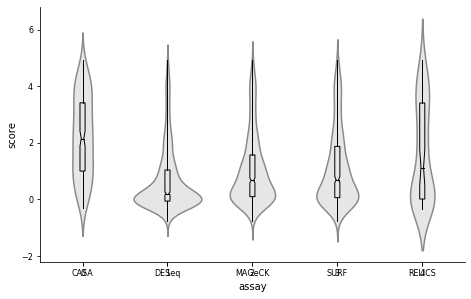

In [66]:
#fig, ax = plt.subplots(figsize=(8,5))
fig = plt.figure(figsize=(8,5))
g = sns.catplot(data=df_marked, x='assay', y='score', kind="violin", color=".9", inner=None, height=4, aspect=1.6)
#sns.violinplot( data=df_marked, x='assay', y='score', ax=ax )
g.ax.boxplot(
    [ 
        df_marked.loc[ df_marked['assay'] == assay, 'score' ].values 
        for assay in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']
    ],
    whis='range', positions=np.array([0,1,2,3,4]),
    showcaps=False,widths=0.06, patch_artist=True,
    notch=True,
    boxprops=dict(color="black", facecolor="None"),
    whiskerprops=dict(linewidth=1),
    medianprops=dict(color="black", linewidth=1 )
)

#sns.boxplot( data=df_marked, x='assay', y='score', notch=True, showfliers=False, showcaps=False, ax=g.ax )

g.savefig('guide_score_distribution_in_peaks.pdf')
plt.show()

number of guides in peaks

In [67]:
df_marked['assay'].value_counts()

DESeq     1218
MAGeCK     715
SURF       623
CASA       204
RELICS      71
Name: assay, dtype: int64

### unfiltered

In [68]:
peak_groups = {}
peak_groups['all'] = merge_bed(unfiltered_peaks.loc[ ~unfiltered_peaks['assay'].str.contains('DHS|ccRE|H3K27ac') ])
for assay in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
    peak_groups[assay] = merge_bed(unfiltered_peaks.loc[ unfiltered_peaks['assay'].str.contains(assay) ])

In [69]:
peak_groups

{'all':      chr      start        end
 0   chrX   48686400   48686700
 1   chrX   48686900   48687200
 2   chrX   48688100   48688200
 3   chrX   48689100   48689500
 4   chrX   48690800   48690900
 5   chrX   48691000   48691400
 6   chrX   48691900   48692100
 7   chrX   48692400   48692800
 8   chrX   48693300   48693400
 9   chrX   48695200   48695300
 10  chrX   48695900   48696400
 11  chrX   48696500   48697000
 12  chrX   48697300   48697500
 13  chrX   48697600   48697700
 14  chrX   48699300   48700300
 15  chrX   48702374   48702974
 16  chrX   48704200   48704600
 17  chrX   48705000   48705800
 18  chrX   48705900   48706300
 19  chrX   48708100   48708200
 20  chrX   48730400   48730800
 21  chrX   48736400   48736800
 22  chrX   48737500   48738000
 23  chrX   48740400   48740814
 24  chrX   48741700   48742100
 25  chrX   48743700   48744100
 26  chrX   48744800   48745200
 27  chrX   48748800   48749100
 28  chrX   48751200   48751300
 29  chrX   48755300   48755400
 

In [70]:
chrom_filter = data['cutsite'].index.str.contains('chrX')
guide_hits = {}
for assay in ['all', 'CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
    guide_hits[assay] = []
    for i, guide in data.iterrows():
        cut_site = np.array([i.split(':')[0], int(guide['cutsite']), int(guide['cutsite']+1)])
        overlaps = check_overlap_bed(cut_site, peak_groups[assay].loc[:,('chr','start','end')].values)
        guide_hits[assay].append( overlaps.sum() > 0 )

    guide_hits[assay] = np.array(guide_hits[assay])

In [72]:
ttests = {}
df_misses = pd.DataFrame( {'score': data.loc[~guide_hits['all'],('ETR1','ETR2')].mean(axis=1), 'assay': 'misses'} )
df_misses = df_misses.loc[ ~df_misses['score'].isna() ]

df_marked = []
df_shufmrk= []
for assay in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
    na_filter = data.loc[:,('ETR1','ETR2')].mean(axis=1).isna()
    
    df_marked.append( 
        pd.DataFrame( {'score': data.loc[guide_hits[assay],('ETR1','ETR2')].mean(axis=1), 'assay': assay} )
    )
    df_shufmrk.append( 
        pd.DataFrame( {'score': data.loc[~na_filter,('ETR1','ETR2')].sample(n=guide_hits[assay].sum()).mean(axis=1), 'assay': assay} )
    )
    df_marked[-1] = df_marked[-1].loc[ ~df_marked[-1]['score'].isna() ]
    ttests[assay] = stats.ttest_ind(df_marked[-1]['score'], df_shufmrk[-1]['score'], equal_var=False)
    
df_marked = pd.concat( df_marked, axis=0 )
df_shufmrk = pd.concat( df_shufmrk, axis=0 )
df_marked['shuffled'] = 'False'

#ttests = {}
#for assay in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']:
#    ttests[assay] = stats.ttest_ind(df_marked.loc[ df_marked['assay'] == assay, 'score' ], df_shufmrk.loc[ df_marked['assay'] == assay, 'score' ], equal_var=False)
    #ttests[assay] = df_marked.loc[ df_marked['assay'] == assay, 'score' ].median() - df_misses['score'].median()


## Results: UNfiltered sgRNA based CREs

test stat and p-values (in -log10 space)

In [73]:
_ = [ print(f"{k}: {-np.log10(v)}") for k,v in ttests.items() ]

CASA: [-1.30207437 55.19308366]
DESeq: [-1.12416096 38.83727222]
MAGeCK: [-1.26410909 65.54388903]
SURF: [-1.23552557 59.1306511 ]
RELICS: [-0.71936382  6.57730143]


violin plots for distributions

<Figure size 576x360 with 0 Axes>

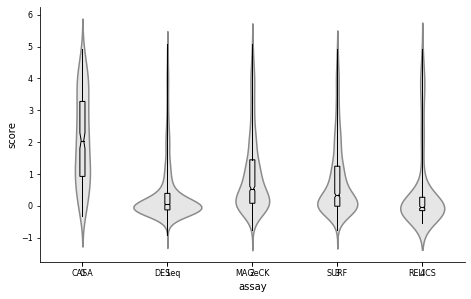

In [74]:
#fig, ax = plt.subplots(figsize=(8,5))
fig = plt.figure(figsize=(8,5))
g = sns.catplot(data=df_marked, x='assay', y='score', kind="violin", color=".9", inner=None, height=4, aspect=1.6)
#sns.violinplot( data=df_marked, x='assay', y='score', ax=ax )
g.ax.boxplot(
    [ 
        df_marked.loc[ df_marked['assay'] == assay, 'score' ].values 
        for assay in ['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS']
    ],
    whis='range', positions=np.array([0,1,2,3,4]),
    showcaps=False,widths=0.06, patch_artist=True,
    notch=True,
    boxprops=dict(color="black", facecolor="None"),
    whiskerprops=dict(linewidth=1),
    medianprops=dict(color="black", linewidth=1 )
)

#sns.boxplot( data=df_marked, x='assay', y='score', notch=True, showfliers=False, showcaps=False, ax=g.ax )

g.savefig('guide_score_distribution_in_peaks.pdf')
plt.show()

number of guides in peaks

In [75]:
df_marked['assay'].value_counts()

DESeq     2579
SURF       955
MAGeCK     829
RELICS     302
CASA       222
Name: assay, dtype: int64

In [76]:
df_marked

,score,assay,shuffled
chrX:48785924-48785944:-,2.282947,CASA,False
chrX:48785781-48785801:-,3.004792,CASA,False
chrX:48786471-48786491:-,1.443079,CASA,False
chrX:48785656-48785676:-,0.657321,CASA,False
chrX:48800807-48800827:+,3.967035,CASA,False
chrX:48783059-48783079:+,4.025354,CASA,False
chrX:48786192-48786212:-,2.162074,CASA,False
chrX:48783070-48783090:+,1.084086,CASA,False
chrX:48785843-48785863:-,0.075934,CASA,False
chrX:48785958-48785978:+,2.795891,CASA,False


# Guide dists

In [39]:
cCRE_call_merge = merge_bed(
    peaks_peaks.loc[
        (peaks_peaks['assay'] != 'H3K27ac') & 
        (peaks_peaks['assay'] != 'DHS') & 
        (peaks_peaks['assay'] != 'ccRE')
    ]
)

highlights = []

highlights.append( cCRE_call_merge.iloc[30:32] )

highlights.append( cCRE_call_merge.iloc[32:33] )

highlights.append( cCRE_call_merge.iloc[40:41] )

highlights.append( cCRE_call_merge.iloc[41:42] )

highlights.append( cCRE_call_merge.iloc[43:45] )

highlights.append( cCRE_call_merge.iloc[47:48] )

highlights.append( cCRE_call_merge.iloc[47:48].copy() )

highlights.append( cCRE_call_merge.iloc[51:52] )

highlights.append( cCRE_call_merge.iloc[53:65] )

highlights.append( cCRE_call_merge.iloc[67:71] )

highlights[5].iloc[0,2]   = 48801000
highlights[6].iloc[0,1] = 48801300

reformat = []
for section in highlights:
    reformat.append(
        {'chr': 'chrX', 'start': section.iloc[0]['start'], 'end': section.iloc[-1]['end']}
    )
    
highlights = pd.DataFrame(reformat).loc[:,('chr','start','end')]
highlights

/home/sagergosai/miniconda3/envs/ccasa/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,chr,start,end
0,chrX,48761500,48762104
1,chrX,48763614,48764100
2,chrX,48781900,48784400
3,chrX,48784600,48788900
4,chrX,48790300,48794400
5,chrX,48799900,48801000
6,chrX,48801300,48802714
7,chrX,48816100,48816900
8,chrX,48817603,48818970
9,chrX,48826294,48827444


In [42]:
highlights.loc[5]

chr          chrX
start    48799900
end      48801000
Name: 5, dtype: object

In [ ]:
multi_region_copypasta(highlights, init_chrom='chrX', init_start=48751841, final_end=48829060)

In [ ]:
ymax = 5.25
ymin = 0.0
std_col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(16,3))
ax  = plt.subplot(111)
glims = [48751841,48829060]
ax.set_xlim( *glims )
ax.set_ylim(ymin, ymax)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
#draw_bed_blocks(ax, peaks_peaks.loc[peaks_peaks['assay']=='H3K27ac', ('chr','start','end')], ylims=[4.0,4.25], color=std_col_cycle[6])
#draw_bed_blocks(ax, peaks_peaks.loc[peaks_peaks['assay']=='DHS', ('chr','start','end')], ylims=[4.50,4.75], color=std_col_cycle[7])
#draw_bed_blocks(ax, peaks_peaks.loc[peaks_peaks['assay']=='ccRE', ('chr','start','end')], ylims=[5.00,5.25], color=std_col_cycle[8])

#draw_bed_blocks(ax, cCRE_call_merge, ylims=[1.0,1.25], color=std_col_cycle[0])
draw_bed_blocks(ax, peaks_peaks.loc[peaks_peaks['assay']=='CASA', ('chr','start','end')], ylims=[1.5,1.75], color=std_col_cycle[1])
draw_bed_blocks(ax, peaks_peaks.loc[peaks_peaks['assay']=='DESeq', ('chr','start','end')], ylims=[2.0,2.25], color=std_col_cycle[2])
draw_bed_blocks(ax, peaks_peaks.loc[peaks_peaks['assay']=='MAGeCK', ('chr','start','end')], ylims=[2.5,2.75], color=std_col_cycle[3])
draw_bed_blocks(ax, peaks_peaks.loc[peaks_peaks['assay']=='SURF', ('chr','start','end')], ylims=[3.0,3.25], color=std_col_cycle[4])
draw_bed_blocks(ax, peaks_peaks.loc[peaks_peaks['assay']=='RELICS', ('chr','start','end')], ylims=[3.5,3.75], color=std_col_cycle[5])

for i,section in highlights.iterrows():
    start = section['start']
    end   = section['end']
    ax.fill_between([start, end], [ymax, ymax], [ymin, ymin], color='black', alpha=0.1)

#plt.vlines([48758495, 48764476, 48780776,48796035, 48798661,48803910], ymin=0., ymax=4., 
#           linewidth=0.5,alpha=0.4)

#plt.savefig('CRISPR_WG/plots/CRISPR_WG__GATA_locus__blocks_only.pdf')

plt.show()

In [75]:
def label_by_cutsite(guide_data, bed_dataframe, flag_label=None, index_label=None):
    labels = []
    for i, line in guide_data.iterrows():
        cutsite = line['cutsite']
        bed_match = bed_dataframe.loc[ (bed_dataframe['start']<=cutsite) & (bed_dataframe['end']>cutsite) ]
        if flag_label is not None:
            if bed_match.shape[0] == 0:
                labels.append(False)
            elif bed_match.shape[0] == 1:
                labels.append(True)
            else:
                raise ValueError("too many hits, merge bed file first")
        elif index_label is not None:
            if bed_match.shape[0] == 0:
                labels.append('NaN')
            elif bed_match.shape[0] == 1:
                labels.append(bed_match.iloc[0].name)
            else:
                raise ValueError("too many hits, merge bed file first")
        else:
            assert False, "Need to pick label style"
    label = flag_label if flag_label is not None else index_label
    new_data = guide_data.copy()
    new_data[label] = labels
    return new_data

In [76]:
refine_data = data.loc[~data['ETR1'].isna(),('ETR1','ETR2','cutsite')].copy()
refine_data['average'] = refine_data.loc[:,('ETR1','ETR2')].mean(axis=1)
refine_data = refine_data.loc[:,('cutsite','average')]
refine_data = label_by_cutsite(refine_data, highlights, index_label='highlights')
non_highlight_median = refine_data.loc[ refine_data['highlights'] == 'NaN','average' ].median()
refine_data = label_by_cutsite(refine_data, peaks_peaks.loc[peaks_peaks['assay']=='CASA', ('chr','start','end')], flag_label='CASA')
refine_data = refine_data.loc[ refine_data['highlights'] != 'NaN' ]
refine_data

,cutsite,average,highlights,CASA
chrX:48761698-48761718:-,48761701,0.308717,0,False
chrX:48761711-48761731:-,48761714,-0.311318,0,False
chrX:48761724-48761744:-,48761727,3.247255,0,False
chrX:48761787-48761807:-,48761790,0.295549,0,False
chrX:48761791-48761811:+,48761807,0.083492,0,False
chrX:48761865-48761885:+,48761881,0.081557,0,False
chrX:48762022-48762042:+,48762038,-0.122946,0,False
chrX:48762030-48762050:+,48762046,0.200789,0,False
chrX:48762081-48762101:+,48762097,0.106705,0,False
chrX:48782833-48782853:+,48782849,0.931962,2,False


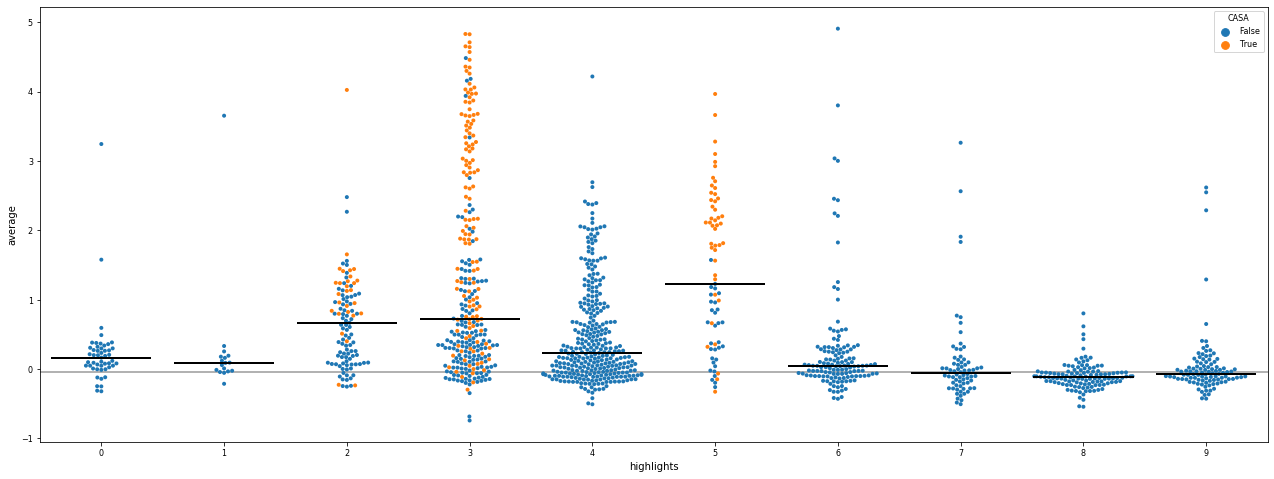

In [164]:
fig = plt.figure(figsize=(22,8))

ax = sns.swarmplot(x="highlights", y="average", hue="CASA", data=refine_data, size=4)

sns.boxplot(medianprops={'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="highlights",
            y="average",
            data=refine_data,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

ax.axhline(y=non_highlight_median, color='black', alpha=0.4)

fig.savefig('CRISPR_WG/plots/GATA1_highlight_guide_distribution.pdf')

plt.show()

In [101]:
label_by_cutsite(refine_data, highlights, index_label='highlights')

,cutsite,average,highlights
chrX:48689307-48689327:-,48689310,-0.058768,NaN
chrX:48689412-48689432:+,48689428,-0.284883,NaN
chrX:48689443-48689463:+,48689459,0.019453,NaN
chrX:48689531-48689551:-,48689534,-0.295159,NaN
chrX:48689687-48689707:-,48689690,-0.014102,NaN
chrX:48695911-48695931:+,48695927,0.051234,NaN
chrX:48696108-48696128:+,48696124,0.106255,NaN
chrX:48696173-48696193:+,48696189,0.175798,NaN
chrX:48696282-48696302:+,48696298,0.049225,NaN
chrX:48696314-48696334:+,48696330,-0.073219,NaN


In [92]:
cCRE_call_merge.loc[ (cCRE_call_merge['start']<=48695100) & (cCRE_call_merge['end']>48695100) ].shape

(0, 3)

In [49]:
peaks_peaks['assay'].unique()

array(['CASA', 'DESeq', 'MAGeCK', 'SURF', 'RELICS', 'H3K27ac', 'DHS',
       'ccRE'], dtype=object)